### Image Captioning 
- Converting Image to a text.
    - Works as visual Aid for blind people.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [2]:
!dir

 Volume in drive E has no label.
 Volume Serial Number is 04E6-2AD8

 Directory of e:\VScode deep learning\Pract LSTM\archive

19-05-2025  21:48    <DIR>          .
19-05-2025  12:41    <DIR>          ..
19-05-2025  12:47    <DIR>          .venv
19-05-2025  12:41         3,319,294 captions.txt
19-05-2025  12:56         2,343,805 description.txt
19-05-2025  21:48         8,251,014 encoded_test_features.pkl
19-05-2025  21:48        49,505,552 encoded_train_features.pkl
19-05-2025  12:36            25,775 Flickr_8k.testImages.txt
19-05-2025  12:36           154,678 Flickr_8k.trainImages.txt
19-05-2025  12:44         1,185,359 Image Captioning .ipynb
19-05-2025  12:41    <DIR>          Images
19-05-2025  12:43    <DIR>          model_weights
21-05-2025  18:51    <DIR>          saved
               7 File(s)     64,785,477 bytes
               6 Dir(s)  484,422,696,960 bytes free


In [3]:
# read text captions

def readTextFile(path):
    with open(path) as f:
        caption = f.read()
    return caption

In [4]:
captions = readTextFile('captions.txt')

In [5]:
captions = captions.split('\n')[:-1]

In [6]:
captions[161]

'1042020065_fb3d3ba5ba.jpg,A boy in a green shirt is looking down at many inflatable boats .'

In [7]:
desc = {}

for x in captions:
    zyzz = x.split(',')
    img_name,img_captions= zyzz[0],zyzz[1]
    
    if desc.get(img_name) is None:
        desc[img_name] = []
    desc[img_name].append(img_captions)


In [8]:
desc['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
import cv2

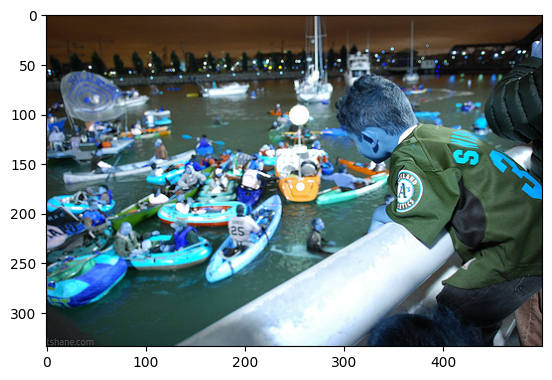

['A boy in a green shirt is looking down at many inflatable boats .',
 'A boy in a green shirt watches kayakers .',
 'A boy looks over a railing at the many boats and rafts below in the water .',
 'A young boy overlooking a crowd of inflatable boats .',
 'A young boy wearing a jersey looks down over a ledge at many boats in the water .']

In [10]:
path = 'Images/1042020065_fb3d3ba5ba.jpg'
plt.imshow(cv2.imread(path))
plt.show()
desc['1042020065_fb3d3ba5ba.jpg']

### Data Cleaning
**HERE**
- Do not remove stopwords
- Do not stemming
- Remove numbers, punctuations

$X \rightarrow MODEL \rightarrow \textbf{Dense layer with soft max}\rightarrow vector[\textbf{probability distribution of each word}]$

In [11]:
import re

In [12]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ', sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s) > 1]
    sentence = ' '.join(sentence)
    return sentence

In [13]:
# clean all captions

In [14]:
for key, caption_list in desc.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [15]:
desc['1042020065_fb3d3ba5ba.jpg']

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [16]:
# write the data to text file 
with open('description.txt','w') as f:
    f.write(str(desc))


### Vocabulary
- It is a set of all possible unique words that model can predict.

In [17]:
import json

In [18]:
descriptions = None
with open('description.txt') as f:
    descriptions = f.read()
json_acceptable_string = descriptions.replace("'","\"")    
descriptions = json.loads(json_acceptable_string)

In [19]:
#descriptions

In [20]:
print(type(descriptions))

<class 'dict'>


In [21]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [22]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size(unique words In Vocab) : %d"% len(vocab))

Vocab Size(unique words In Vocab) : 8258


In [23]:
vocab = set()
vocab.update(["hello", "apple"])
vocab.update(["hello"])
vocab.update(["hi"])
print(vocab)

{'hello', 'hi', 'apple'}


In [24]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [25]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))


Total Words 357792


In [26]:
len(total_words), type(total_words)

(357792, list)

In [27]:
# filter words from vocab according to certain threshold frequency

In [28]:
import collections
counter = collections.Counter(total_words)
frq_cnt = dict(counter)
print(len(frq_cnt.keys()))
print(frq_cnt)

8258
{'caption': 1, 'child': 1517, 'in': 18193, 'pink': 706, 'dress': 332, 'is': 9069, 'climbing': 495, 'up': 1251, 'set': 106, 'of': 6504, 'stairs': 109, 'an': 2358, 'entry': 1, 'way': 51, 'girl': 3284, 'going': 145, 'into': 1046, 'wooden': 278, 'building': 485, 'little': 1750, 'playhouse': 6, 'the': 17677, 'to': 3008, 'her': 1102, 'cabin': 4, 'black': 3641, 'dog': 7958, 'and': 8066, 'spotted': 37, 'are': 3365, 'fighting': 131, 'tri': 12, 'colored': 204, 'playing': 1954, 'with': 7308, 'each': 399, 'other': 667, 'on': 10369, 'road': 389, 'white': 3728, 'brown': 2484, 'spots': 28, 'staring': 57, 'at': 2820, 'street': 910, 'two': 5550, 'dogs': 2097, 'different': 44, 'breeds': 5, 'looking': 683, 'pavement': 46, 'moving': 40, 'toward': 142, 'covered': 348, 'paint': 58, 'sits': 561, 'front': 1322, 'painted': 63, 'rainbow': 17, 'hands': 231, 'bowl': 29, 'sitting': 1322, 'large': 1210, 'small': 1264, 'grass': 1565, 'plays': 515, 'fingerpaints': 3, 'canvas': 6, 'it': 370, 'there': 296, 'pigtai

In [29]:
# sort the dictionary according to the freq count

sorted_freq_cnt = sorted(frq_cnt.items(), reverse = True, key=lambda x:x[1])

# filter
threshold =  10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [30]:
#sorted_freq_cnt

In [31]:
print(len(total_words)) # 1800 unique words filter, this is going to be new vocab size

1800


In [32]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

### Train/Test Data

In [33]:
len(descriptions.keys()), len(descriptions.values())

(8092, 8092)

In [34]:
train_file_data = readTextFile('Flickr_8k.trainImages.txt')
test_file_data = readTextFile('Flickr_8k.testImages.txt')

In [35]:
train = [row.split('.')[0] for row in train_file_data.split('\n')[:-1]]
test = [row.split('.')[0] for row in test_file_data.split('\n')[:-1]]

In [36]:
len(train), len(test)

(6000, 1000)

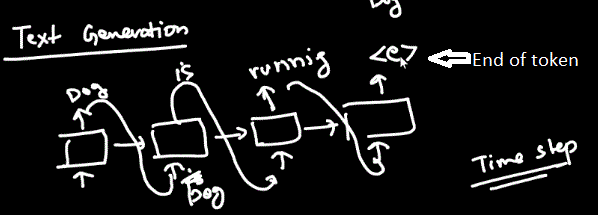
- This model will be able to **generate end of sentence token** only if we have the token in out training data.
- What we will do is that, when the caption is given we will add start and end token to it.
- $<start>$ DOG IS BARKING $<end>$

In [37]:
print(descriptions.get('1000268201_693b08cb0e.jpg'))

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [38]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [39]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id+'.jpg']:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [40]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Transfer Learning
- Images -> Features
- Text -> Features
<br>

### Step 1: Image Feature Extraction
   - Using ResNet50 to extract features which is already trained on imagenet.
   - Resnet50 is very deep model it has 50 layers with skip connection they dont have suffer from Vanishing Gradient. 
   - ResNe50 is not a sequential model it can skip connetions.

In [41]:
model = ResNet50(weights = 'imagenet', input_shape = (224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [42]:
model_new = Model(model.input,model.layers[-2].output)

In [43]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


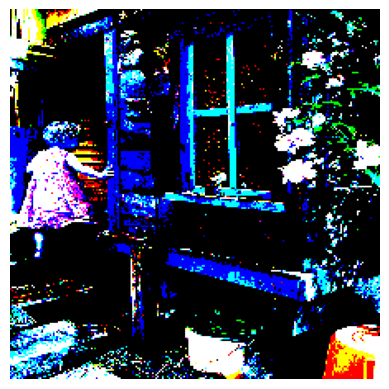

In [44]:
img = preprocess_img('Images/'+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [45]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)  
    feature_vector = feature_vector.reshape((2048,))
    #print(feature_vector.shape)
    return feature_vector

In [46]:
encode_image('Images/'+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 3s 3s/step


array([0.0653655 , 0.16782689, 0.3251846 , ..., 0.0511154 , 0.32817933,
       1.0043333 ], dtype=float32)

In [47]:
type(train)

list

In [48]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image
for ix,img_id in enumerate(train):
    img_path = 'Images'+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    if ix%100==0:
        print("Encoding in progress time step %d "%ix)
end_t = time()
print("Total Time Taken :",end_t-start)

1/1 [==============================] - 0s 136ms/step
Encoding in progress time step 0 
1/1 [==============================] - 0s 341ms/step
Encoding in progress time step 100 
1/1 [==============================] - 0s 249ms/step
Encoding in progress time step 200 
1/1 [==============================] - 0s 192ms/step
Encoding in progress time step 300 
1/1 [==============================] - 0s 194ms/step
Encoding in progress time step 400 
1/1 [==============================] - 0s 216ms/step
Encoding in progress time step 500 
1/1 [==============================] - 0s 207ms/step
Encoding in progress time step 600 
1/1 [==============================] - 0s 206ms/step
Encoding in progress time step 700 
1/1 [==============================] - 0s 191ms/step
Encoding in progress time step 800 
1/1 [==============================] - 0s 327ms/step
Encoding in progress time step 900 
1/1 [==============================] - 0s 406ms/step
Encoding in progress time step 1000 
1/1 [=================

In [49]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image
for ix,img_id in enumerate(test):
    img_path = 'Images'+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    if ix%50==0:
        print("Encoding in progress time step %d "%ix)
end_t = time()
print("Total Time Taken :",end_t-start)

1/1 [==============================] - 0s 365ms/step
Encoding in progress time step 0 
1/1 [==============================] - 0s 310ms/step
Encoding in progress time step 50 
1/1 [==============================] - 0s 303ms/step
Encoding in progress time step 100 
1/1 [==============================] - 0s 260ms/step
Encoding in progress time step 150 
1/1 [==============================] - 0s 282ms/step
Encoding in progress time step 200 
1/1 [==============================] - 0s 276ms/step
Encoding in progress time step 250 
1/1 [==============================] - 0s 325ms/step
Encoding in progress time step 300 
1/1 [==============================] - 0s 305ms/step
Encoding in progress time step 350 
1/1 [==============================] - 0s 276ms/step
Encoding in progress time step 400 
1/1 [==============================] - 0s 269ms/step
Encoding in progress time step 450 
1/1 [==============================] - 0s 311ms/step
Encoding in progress time step 500 
1/1 [===================

In [50]:
!mkdir saved

A subdirectory or file saved already exists.


In [51]:
# # Store everything to the disk 
import pickle

with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [52]:
#data preprocessing for captions

In [53]:
len(total_words)

1800

In [54]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [55]:
word_to_idx['dog']
idx_to_word[1]

'in'

In [56]:
len(idx_to_word)

1800

In [57]:
idx_to_word[1801] = 'startseq'
word_to_idx['startseq'] = 1801

idx_to_word[1802] = 'endseq'
word_to_idx['endseq'] = 1802

In [58]:
vocab_size =len(word_to_idx)+1
print(vocab_size)

1803


In [59]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

30


- Your current prediction is dependent on the past results.
- $P(w_{t+1}|w_{1}....w_{t})$ whatever word we predict at current timestamp let say $W_{t+1}$ depends on what we have generated from $w_{1}....w_{t}$ 
- In markov chain we were only looking at 4 previous chars.
- But In RNN/LSTM we can look back in entire sequence.

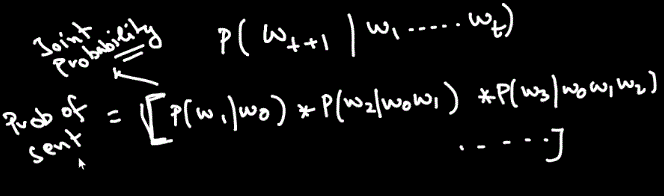


https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

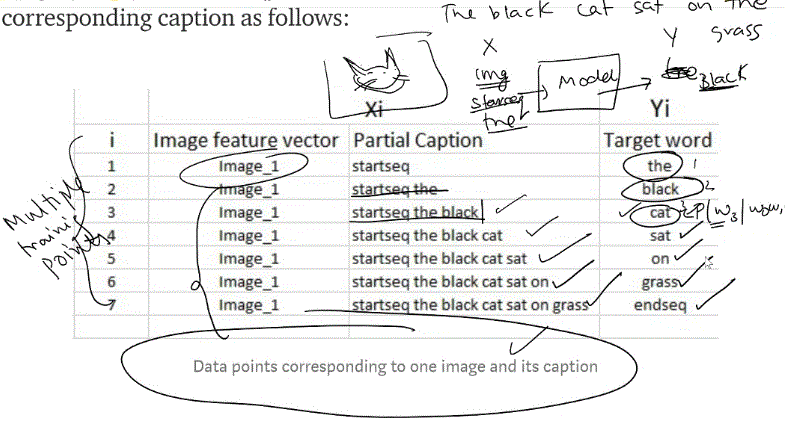

### Data Loader

In [60]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorcial([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [62]:
with open("saved/glove/6B/glove.6B.50d.txt", encoding='utf8') as f:
    glove = [line.split() for line in f]


In [64]:
import numpy as np

embedding_index = {}

with open("saved/glove/6B/glove.6B.50d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        word_embedding = np.array(values[1:], dtype='float32')
        embedding_index[word] = word_embedding


In [65]:
embedding_index['apple'] # embedding for apple

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ], dtype=float32)

In [66]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [67]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1803, 50)

### Model Architecture
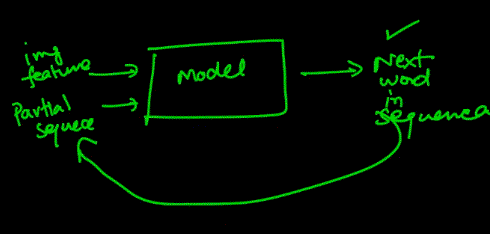

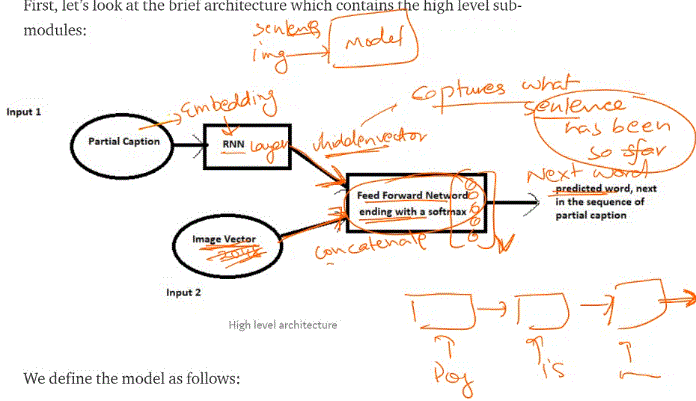

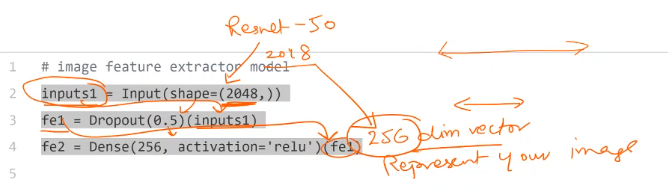

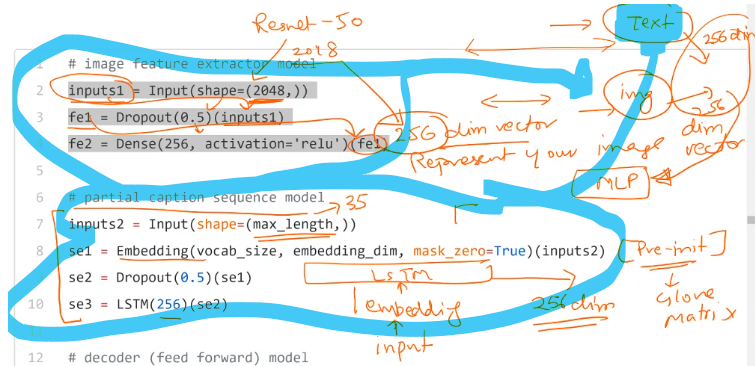

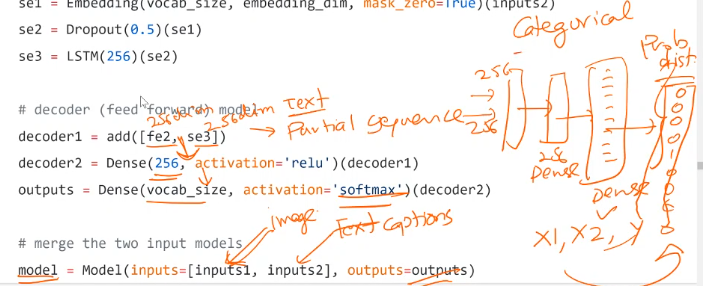

In [68]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [69]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [78]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add
import numpy as np

# Hyperparameters
vocab_size = 10000
max_length = 34

# Image feature input
input_img_features = Input(shape=(4096,), name='img_input')
inp_img2 = Dropout(0.5)(input_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img2)

# Caption input
input_captions = Input(shape=(max_length,), name='caption_input')
inp_cap3 = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(input_captions)
inp_cap3 = Dropout(0.5)(inp_cap3)
inp_cap3 = LSTM(256)(inp_cap3)

# Merge
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Combined model
model = Model(inputs=[input_img_features, input_captions], outputs=outputs)


In [79]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 caption_input (InputLayer)     [(None, 34)]         0           []                               
                                                                                                  
 img_input (InputLayer)         [(None, 4096)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 34, 256)      2560000     ['caption_input[0][0]']          
                                                                                                  
 dropout_4 (Dropout)            (None, 4096)         0           ['img_input[0][0]']              
                                                                                            

In [82]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add
import numpy as np

# Example dimensions
vocab_size = 10000
embedding_dim = 50
max_length = 34

# Dummy embedding matrix
embedding_matrix = np.random.rand(vocab_size, embedding_dim)

# Inputs
input_img_features = Input(shape=(4096,))
x1 = Dropout(0.5)(input_img_features)
x1 = Dense(256, activation='relu')(x1)

input_captions = Input(shape=(max_length,))
# Assign embedding layer to a variable
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, mask_zero=True)
x2 = embedding_layer(input_captions)
x2 = Dropout(0.5)(x2)
x2 = LSTM(256)(x2)

# Merge and continue
decoder1 = add([x1, x2])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input_img_features, input_captions], outputs=outputs)

# ✅ Set pretrained weights and freeze the embedding layer
embedding_layer.set_weights([embedding_matrix])
embedding_layer.trainable = False

model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 34, 50)       500000      ['input_6[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 4096)         0           ['input_5[0][0]']                
                                                                                            

- categorical_crossentropy is used with large no. of classes

In [83]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [89]:
# model training 
epochs = 20
batch_size = 3
steps = len(train_descriptions)//64


In [93]:

import tensorflow as tf

tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Considering batch size to be 3 ,
at each step we would be training our for 1 batch , means 3 images with there respective captions . So , the number of pics per batch will be equal to batch_Size.
hence, number of pics per batch is 3.

and steps = 1000 //3 = 33 ( assuming your len( train_descriptions ) = 1000 )

In [94]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [95]:
model = load_model('./model_weights/model_9.h5')

## FINAL PREDICTIONS

In [97]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        final_caption = set()
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() 
        word = idx_to_word[ypred]
        in_text = ' ' + word
        final_caption.add(in_text)
        
        print(in_text)
        
        if word == "endseq":
            break
    
#         final_caption = in_text.split()[1:-1]
        st = ' '.join(final_caption)
        final_caption.clear()
    
    return st

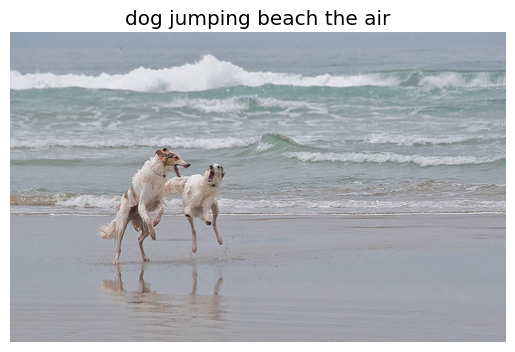

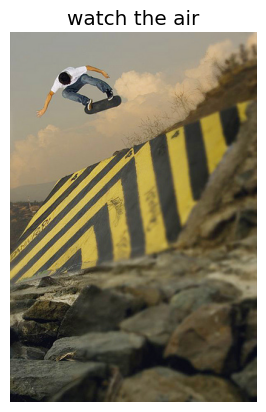

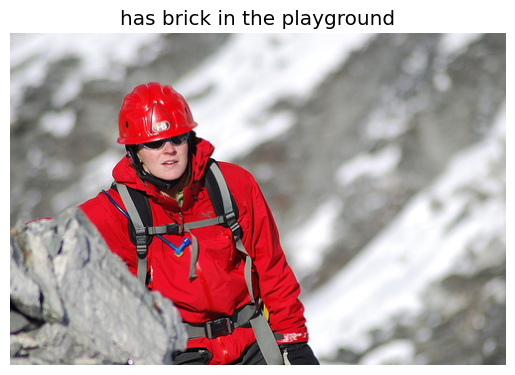

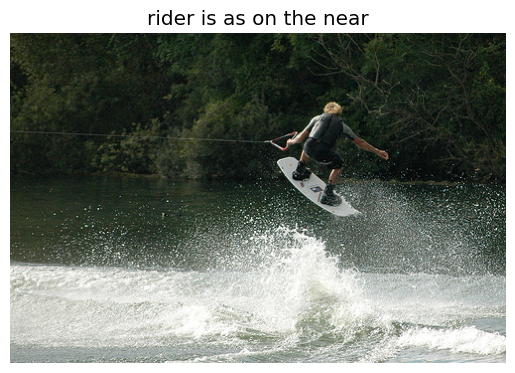

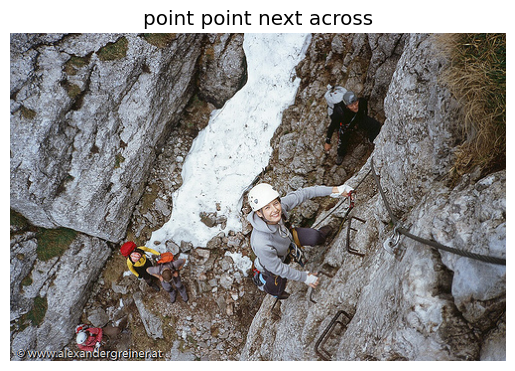

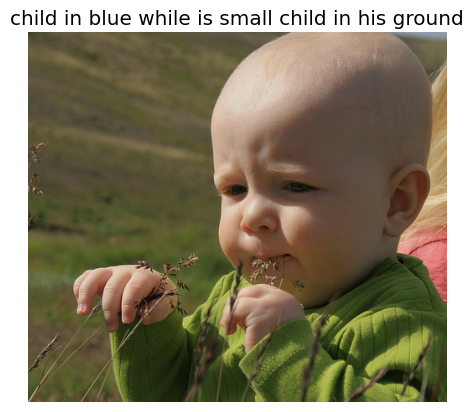

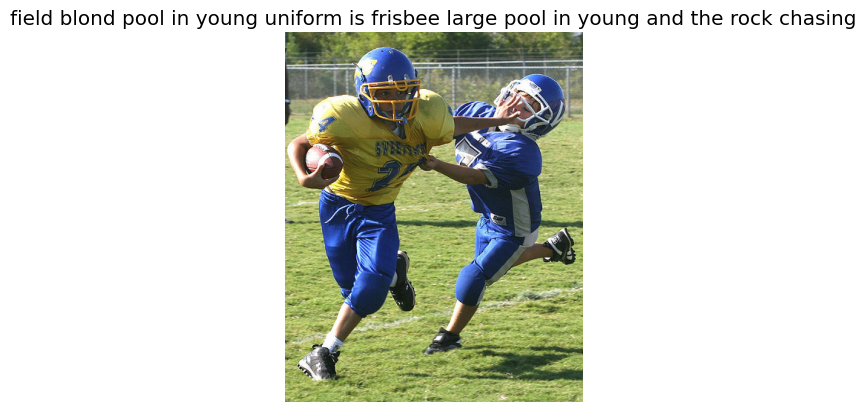

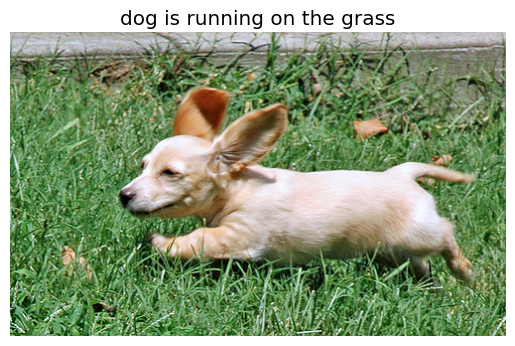

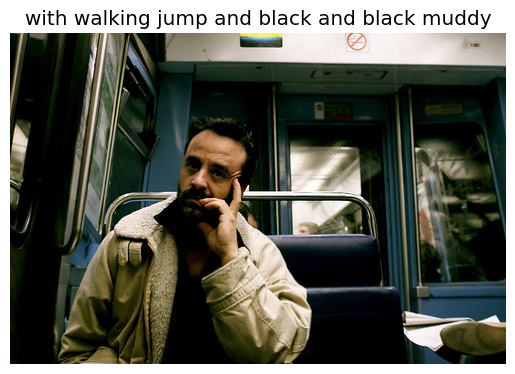

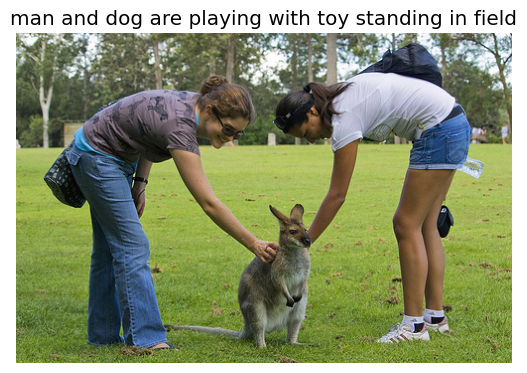

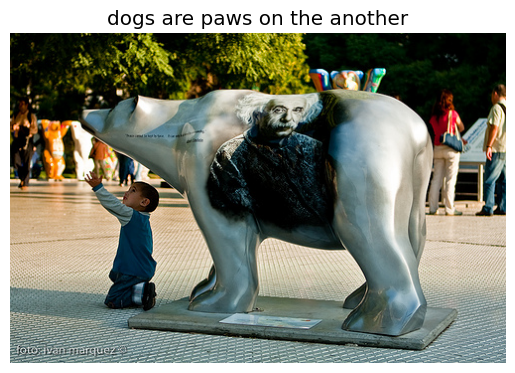

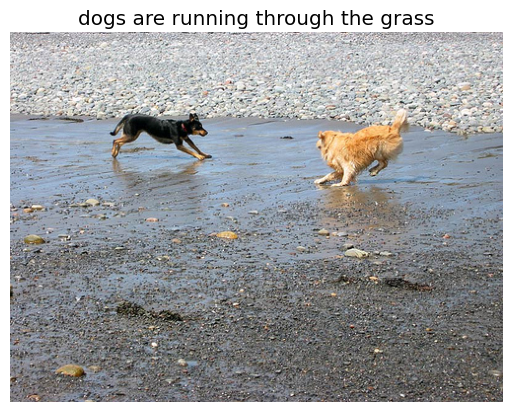

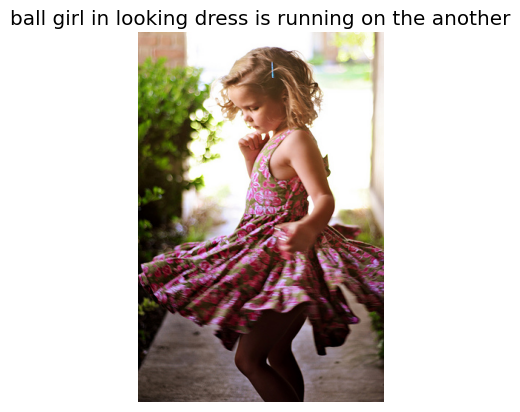

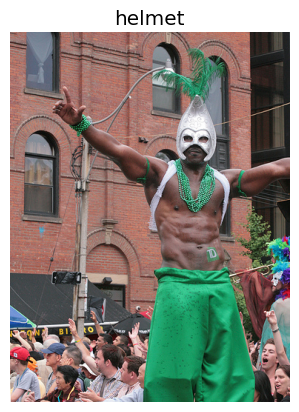

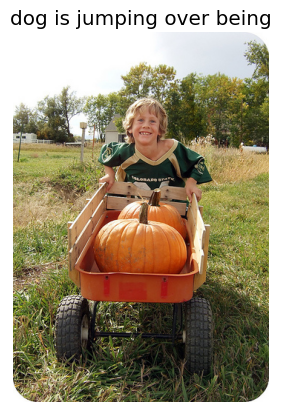

In [108]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

plt.style.use("ggplot")  # Safe default style

max_len = 35  # Must match model's expected caption length

def predict_caption(photo):
    in_text = 'startseq'
    for _ in range(max_len):
        # Convert words to sequence of indices
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        # Pad sequence to max_len (fixed length expected by model)
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        # Predict next word
        ypred = model.predict([photo, sequence], verbose=0)
        ypred = ypred.argmax(axis=-1)[0]  # index of predicted word
        word = idx_to_word.get(ypred, None)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    # Remove startseq and endseq tokens before returning
    return in_text.replace('startseq ', '').replace(' endseq', '')

all_img_names = list(encoding_test.keys())

for _ in range(15):
    idx = np.random.randint(0, len(all_img_names))
    img_name = all_img_names[idx]

    photo_2048 = encoding_test[img_name].reshape((1, 2048))
    img = plt.imread("Images/" + img_name + ".jpg")

    caption = predict_caption(photo_2048)  # Now returns clean caption without special tokens

    plt.imshow(img)
    plt.title(caption)
    plt.axis("off")
    plt.show()


In [109]:
len(encoding_test)

1000